In [1]:
from roboflow import Roboflow
import os
from PIL import Image
import re

In [2]:
rf = Roboflow(api_key="ItoeXESUR3kCkABf6b9l")
project = rf.workspace().project("windows-instance-segmentation")
model = project.version(3).model

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import pandas as pd

# add direction column to store the number of windows in that wall
school = pd.read_csv("School_ID_and_CORDS.csv")
school.head(2)
school['N'] = 0
school['E'] = 0
school['S'] = 0
school['W'] = 0

school['NE'] = 0
school['SE'] = 0
school['SW'] = 0
school['NW'] = 0
school.head(2)

,SchoolName,NCESID,Lat,Long,N,E,S,W,NE,SE,SW,NW
0,Another Course To College,250279000698,42.265168,-71.117736,0,0,0,0,0,0,0,0
1,Baldwin Early Learning Center,250279000011,42.342017,-71.140534,0,0,0,0,0,0,0,0


In [4]:
school.head(2)

,SchoolName,NCESID,Lat,Long,N,E,S,W,NE,SE,SW,NW
0,Another Course To College,250279000698,42.265168,-71.117736,0,0,0,0,0,0,0,0
1,Baldwin Early Learning Center,250279000011,42.342017,-71.140534,0,0,0,0,0,0,0,0


In [5]:
folder_path = "./dataset"

# Pre-clear the dataset file
# transfer the jpg and png into jepg
# clear all predict image at first

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        filepath = os.path.join(folder_path, filename)
        #print(filepath)
        with Image.open(filepath) as img:
            print(f"{filename}: {img.size}")
            rgb_img = img.convert("RGB")
            rgb_img.save(folder_path + "/" + filename[:-3] + "jpeg", "JPEG")
            os.remove(filepath)
    if filename[-12:-5]=="predict":
        os.remove(os.path.join(folder_path, filename))

In [6]:
# doing the window segmentation and generate the predict image
# for example: AbcSchool_NW.jpeg ---> AbcSchool_NW_redict_jpeg

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        filepath = os.path.join(folder_path, filename)
        with Image.open(filepath) as img:
            
            try:
                a = model.predict(filepath)
                a_json = a.json()
                a.save(filepath[:-5]+"_predict.jpeg")
                number_window = len(a.predictions)
                start_index = filepath.rfind("_") + 1 
                end_index = filepath.rfind(".")
                direction = filepath[start_index:end_index]
                the_str = filename[:filename.rfind("_")]
                divide = re.sub(r'([A-Z])', r' \1', the_str).strip()
                row_index = school[school['SchoolName'].str.contains(divide)].index[0]
                school.loc[row_index, direction] = number_window
    
                print(filename + " window segmentation completed.")
            except:
                print(filename+' generate prediction FAILED.')

BostonLatin_E.jpeg window segmentation completed.
EastBostonHigh_S.jpeg window segmentation completed.
CarterSchool_NE.jpeg window segmentation completed.
CharlestownHigh_E.jpeg window segmentation completed.
BostonCommunityLeadershipAcademy_W.jpeg window segmentation completed.
BostonLatinAcademy_N.jpeg window segmentation completed.
CarterSchool_SE.jpeg window segmentation completed.
BostonGreenAcademyHoraceMannCharterSchool_S.jpeg window segmentation completed.
BostonInternationalHighSchool_S.jpeg window segmentation completed.
BostonCommunityLeadershipAcademy_E.jpeg window segmentation completed.
CarterSchool_SW.jpeg window segmentation completed.
BostonArtsAcademy_SW.jpeg window segmentation completed.
BostonLatin_W.jpeg window segmentation completed.
BostonAdultAcademy_E.jpeg window segmentation completed.
CharlestownHigh_N.jpeg window segmentation completed.
AnotherCourseToCollege_S.jpeg window segmentation completed.
BostonArtsAcademy_NW.jpeg window segmentation completed.
Cart

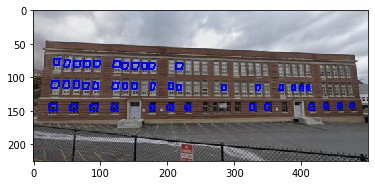

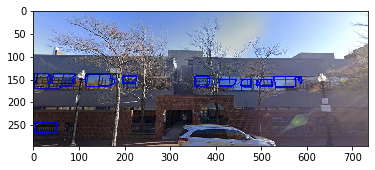

In [7]:
# Take a glimpse about the predicted image.

import cv2
from matplotlib import pyplot as plt
index = 0
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        filepath = os.path.join(folder_path, filename)
        if "predict" not in filename:
            continue
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
        index+=1 
    if index>1:
        break

In [8]:
# show the counting number of the different directions in different schools.
school.head(5)

,SchoolName,NCESID,Lat,Long,N,E,S,W,NE,SE,SW,NW
0,Another Course To College,250279000698,42.265168,-71.117736,5,0,2,9,0,0,0,0
1,Baldwin Early Learning Center,250279000011,42.342017,-71.140534,0,0,0,0,28,57,0,37
2,Beethoven,250279000198,42.263650,-71.155682,0,0,0,0,0,6,0,0
3,Blackstone,250279000201,42.340724,-71.071883,0,0,0,0,11,0,0,9
4,Boston Adult Academy,250279001511,42.348671,-71.068159,0,20,17,0,0,0,0,0


In [9]:
# # infer on a local image
# print(model.predict("your_image.jpg").json())

# # infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE").json())

# # save an image annotated with your predictions
# model.predict("your_image.jpg").save("prediction.jpg")